In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import scipy.io

data = scipy.io.loadmat('Xtrain.mat')
time_series = data['Xtrain'].reshape(-1).astype(float)
print(f"{len(time_series)} data points")


1000 data points


In [ ]:
def create_dataset(dataset, look_back=1):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back)])
        y.append(dataset[i + look_back])

    return np.array(X), np.array(y)


In [ ]:
def evaluate_look_back_values(time_series, max_look_back=20):
    mse_scores = []
    train_size = int(len(time_series) * 0.8)
    
    for look_back in range(1, max_look_back + 1):
        X, y = create_dataset(time_series, look_back)
        X_train, X_val = X[:train_size - look_back], X[train_size - look_back:]
        y_train, y_val = y[:train_size - look_back], y[train_size - look_back:]
       
        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()

        X_train_scaled = scaler_X.fit_transform(X_train)
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
        X_val_scaled = scaler_X.transform(X_val)

        model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
        model.fit(X_train_scaled, y_train_scaled)

        y_val_pred_scaled = model.predict(X_val_scaled)
        y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).flatten()

        mse = mean_squared_error(y_val, y_val_pred)
        mse_scores.append(mse)
        
    return mse_scores


 Optimal look-back value: 17 with MSE: 39.3107


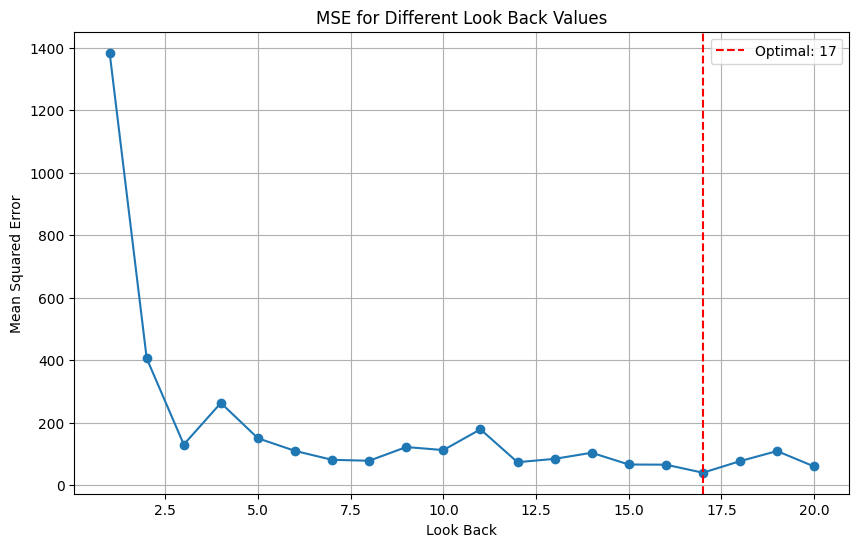

In [21]:
mse_scores = evaluate_look_back_values(time_series, max_look_back=20)
optimal_look_back = np.argmin(mse_scores) + 1
print(f" Optimal look-back value: {optimal_look_back} with MSE: {mse_scores[optimal_look_back-1]:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(mse_scores) + 1), mse_scores, marker='o')
plt.axvline(optimal_look_back, color='red', linestyle='--', label=f'Optimal: {optimal_look_back}')
plt.xlabel('Look Back')
plt.ylabel('Mean Squared Error')
plt.title('MSE for Different Look Back Values')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
def train_and_predict_future(time_series, look_back, future_steps=200):
    X, y = create_dataset(time_series, look_back)

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

    model = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=2000, early_stopping=True,
                         validation_fraction=0.1, random_state=42)
    model.fit(X_scaled, y_scaled)

    train_pred_scaled = model.predict(X_scaled)
    train_pred = scaler_y.inverse_transform(train_pred_scaled.reshape(-1, 1)).flatten()

    future_predictions = []
    current_window = time_series[-look_back:].copy()

    for _ in range(future_steps):
        current_window_scaled = scaler_X.transform(current_window.reshape(1, -1))
        next_scaled = model.predict(current_window_scaled)
        next_value = scaler_y.inverse_transform(next_scaled.reshape(-1, 1)).flatten()[0]
        future_predictions.append(next_value)
        current_window = np.append(current_window[1:], next_value)

    return future_predictions, train_pred


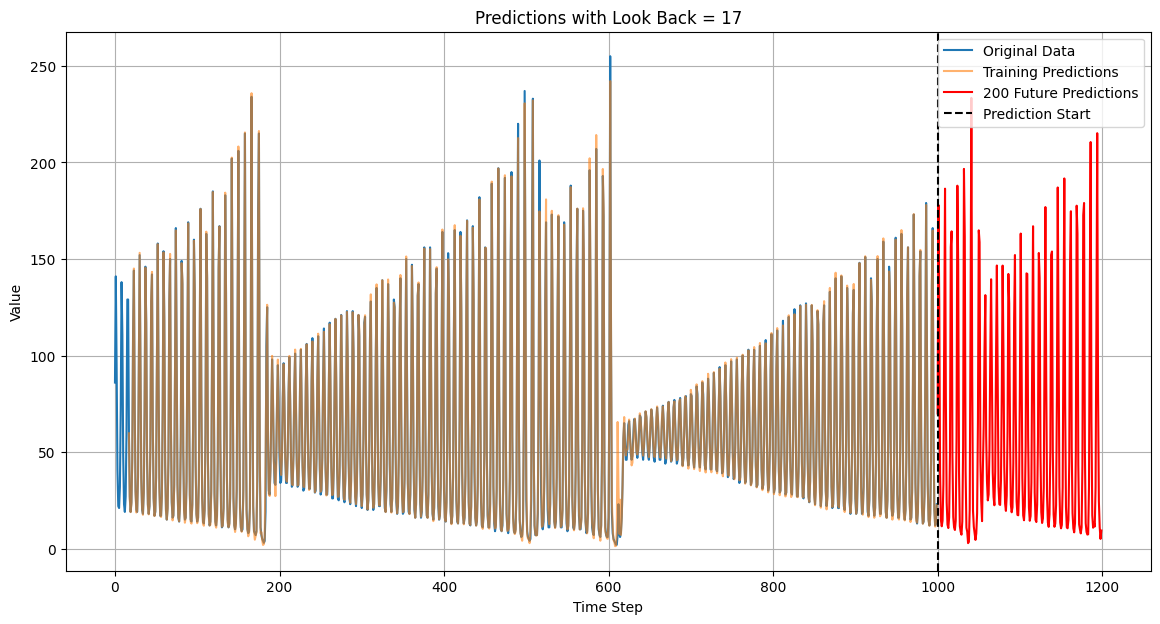

200 future predictions:

[ 69.99 177.95 126.04  39.01  14.75  11.57  14.43  33.41 112.91 186.41
  78.42  23.99  12.39  10.65  16.22  49.3  156.08 164.31  48.25  16.37
  10.98   9.63  14.43  57.61 187.95 147.12  40.05  11.61   8.72   7.22
  14.11  52.67 196.64 161.43  40.3   10.8    8.66   2.83   3.56  20.29
 114.41 233.42  90.1   19.62  11.27   7.97   4.51   7.85  18.34  65.65
 164.83 158.68  45.31  24.82  14.23  41.17  63.59 103.34 131.27  58.4
  34.76  24.97  28.04  50.85  99.36 139.48  89.12  39.41  26.73  22.44
  39.96  98.73 146.61  91.48  32.11  22.92  22.62  35.37  80.55 146.56
 102.44  42.83  23.34  19.54  27.39  60.98 142.24 126.96  57.89  22.86
  18.81  21.41  44.26 119.05 152.04  70.6   24.52  17.46  17.26  30.64
  83.4  163.15 101.72  36.44  17.16  14.68  22.08  52.85 142.54 142.27
  57.97  21.17  14.41  16.86  34.17 100.3  166.95  89.9   28.99  14.82
  13.76  22.7   57.99 153.1  140.13  49.94  18.92  13.28  15.64  31.67
 101.95 176.88  88.21  27.09  13.57  11.26  17.73  50

In [16]:
future_predictions, train_pred = train_and_predict_future(
    time_series, optimal_look_back, future_steps=200
)

plt.figure(figsize=(14, 7))
plt.plot(time_series, label='Original Data')
plt.plot(range(optimal_look_back, optimal_look_back + len(train_pred)), train_pred,
         label='Training Predictions', alpha=0.6)
plt.plot(range(len(time_series), len(time_series) + 200), future_predictions,
         label='200 Future Predictions', color='red')
plt.axvline(x=len(time_series), linestyle='--', color='black', label='Prediction Start')
plt.title(f'Predictions with Look Back = {optimal_look_back}')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

print("200 future predictions:\n")
print(np.round(future_predictions, 2))
